# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import shutil
import matplotlib.pyplot as plt

# Understanding Benign Data

In [2]:
BATCH_SIZE=16

In [3]:
im = Image.open('data/benign/img/1.png')
# im.show()
image_size = np.array(im).shape
image_size

(471, 562, 3)

In [4]:
# im.show()
im2 = im.crop((57,0,505,448))
# im2.show()
im2=np.array(im2)/255.
im2.shape
# im2[0] = [np.mean(im2[0])]
im2[:,:,0].shape

(448, 448)

In [5]:
# os.mkdir('delete/')
# shutil.move('garbage.txt', 'delete/garbage.txt')

In [6]:
data_path_img = 'data/normal/'

def refactor_path(data_path):
    if not os.path.exists(data_path+'img/'):
        os.mkdir(data_path+'img/')
    if not os.path.exists(data_path+'mask/'):
        os.mkdir(data_path+'mask/')

    for file in os.listdir(data_path):
        if file[-3:] == 'png':
            if file[-8:-4] == 'mask':
                num = file.split('(')
                num = int(num[1].split(')')[0])
                shutil.move(f'{data_path}{file}', f'{data_path}mask/{num}.png')
            else:
                num = file.split('(')
                num = int(num[1].split(')')[0])
                shutil.move(f'{data_path}{file}', f'{data_path}img/{num}.png')

# refactor_path(data_path_img)


In [7]:
data_path_img = 'data/benign/img/'
data_path_mask = 'data/benign/mask/'


for file in os.listdir(data_path_img):
    im = Image.open(data_path_img+file)
    im = np.array(im)
    # print(f"file: {len(im.shape)}")
    if len(im.shape) == 3 and im.shape[2]==4:
        print(f"delete: {file}")
        os.remove(data_path_img+file)
        os.remove(data_path_mask+file)


# files = ["163.png",
# "173.png",
# "98.png",
# "100.png",
# "315.png",
# "181.png",
# "83.png",
# "93.png"]
# for file in files:
#     print(f"delete: {data_path_mask+file}")
#     os.remove(data_path_mask+file)


In [8]:
data_path_img = 'data/benign/img/'

In [9]:
class CustomDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size=32, shuffle=False):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.n = len(self.df)


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    

    def __get_input(self, paths):
        out = []

        for path in paths:
            inc_next = False
            im = Image.open(path)
            im = im.crop((57,0,505,448))
            im = np.array(im)/255.

            out.append(im)

        return out


    def __get_output(self, labels):
        out = []

        for label in labels:
            im = Image.open(label)
            im = im.crop((57,0,505,448))
            im = np.array(im)/1.
            im = im.reshape((448,448,1))
            # im = np.broadcast_to(im,(448,448,3))
            
            # print('out', im.shape)
            # im = im[:,:,0]
            
            out.append(im)

        return out


    def __get_data(self, batches):
        paths = batches[self.X_col]
        X = self.__get_input(paths)
        labels = batches[self.y_col]
        y = self.__get_output(labels)
        X = np.array(X, dtype=object)
        y = np.array(y, dtype=object)
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        return X,y


    def __getitem__(self, index):
        batches = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        X,y = self.__get_data(batches)
        return X,y


    def __len__(self):
        return self.n // self.batch_size


In [10]:
img_path = 'data/benign/img/'
img_files = os.listdir(img_path)
img_files = [img_path+i for i in img_files]

mask_path = 'data/benign/mask/'
mask_files = os.listdir(mask_path)
mask_files = [mask_path+i for i in mask_files]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    img_files, mask_files,
    test_size=.33,
    random_state=42
)

train_df = pd.DataFrame({'img':X_train, 'labels':y_train})
val_df = pd.DataFrame({'img':X_test, 'labels':y_test})
train_df, val_df

(                         img                    labels
 0    data/benign/img/224.png  data/benign/mask/224.png
 1    data/benign/img/280.png  data/benign/mask/280.png
 2    data/benign/img/421.png  data/benign/mask/421.png
 3    data/benign/img/130.png  data/benign/mask/130.png
 4    data/benign/img/403.png  data/benign/mask/403.png
 ..                       ...                       ...
 281   data/benign/img/58.png   data/benign/mask/58.png
 282  data/benign/img/364.png  data/benign/mask/364.png
 283   data/benign/img/31.png   data/benign/mask/31.png
 284  data/benign/img/431.png  data/benign/mask/431.png
 285  data/benign/img/166.png  data/benign/mask/166.png
 
 [286 rows x 2 columns],
                          img                    labels
 0    data/benign/img/153.png  data/benign/mask/153.png
 1    data/benign/img/398.png  data/benign/mask/398.png
 2     data/benign/img/38.png   data/benign/mask/38.png
 3    data/benign/img/411.png  data/benign/mask/411.png
 4    data/benign/img

In [12]:
traingen = CustomDataGenerator(train_df, 'img', 'labels', BATCH_SIZE)
valgen = CustomDataGenerator(val_df, 'img', 'labels', BATCH_SIZE)
traingen, valgen

(<__main__.CustomDataGenerator at 0x17fb97460>,
 <__main__.CustomDataGenerator at 0x17fb97280>)

In [13]:
# len(traingen.__getitem__(0)[0])
len(traingen.__getitem__(0)[1])
# c = 0
# for data in traingen:
#     print(c, len(data))
#     c += 1

16

In [14]:
# traingen.__getitem__(11)[0][4][0][1]

# UNet model

In [15]:
from unet import UNet

model = UNet((448,448,3))
model

In [16]:
# model.summary()

In [17]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

In [18]:
if os.path.exists('checkpoint/unet_best/'):
    model.load_weights('checkpoint/unet_best/')

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    epsilon=1e-07,
)

# loss = tf.keras.losses.BinaryCrossentropy()
loss = DiceLoss()

model.compile(
    optimizer=opt,
    loss=loss,
    # metrics=['accuracy']
)

In [19]:
EPOCHS = 50

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/unet',
    verbose=1,
    monitor='loss',
    save_best_only=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_delta=0.0001,
    cooldown=3,
    min_lr=1e-8,
)

# model.fit(
#     traingen,
#     epochs=EPOCHS,
#     verbose=1,
#     # validation_data=valgen,
#     callbacks=[checkpoint, lr_reduction]
# )

In [20]:
model.load_weights('checkpoints/unet_best_0.04779//') # 0.04779

In [21]:
test = valgen.__getitem__(0)
img = test[0][6]
mask = test[1][6]

In [22]:
img.shape, mask.shape

(TensorShape([448, 448, 3]), TensorShape([448, 448, 1]))

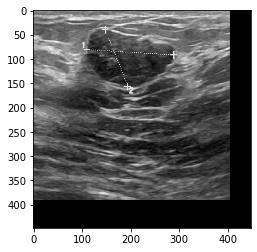

In [23]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

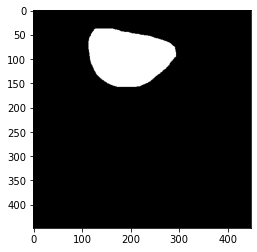

In [24]:
plt.imshow(mask, cmap='gray')
plt.show()

In [25]:
pred = model.predict(tf.convert_to_tensor([img]))
pred = pred[0]

def fn(x):
    return 0. if x < 0.5 else 1.
fn = np.vectorize(fn)
pred = fn(pred)
min(np.unique(pred))

0.0

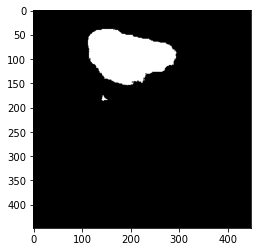

In [26]:
plt.imshow(pred, cmap='gray')
plt.show()

# Enet experimentation

In [27]:
from enet import ENet

model = ENet(n_classes=1, input_height=448, input_width=448)
model

In [29]:
# model.summary()

In [30]:
if os.path.exists('checkpoint/enet_best/'):
    model.load_weights('checkpoint/enet_best/')

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    epsilon=1e-07,
)

# loss = tf.keras.losses.BinaryCrossentropy()
loss = DiceLoss()

model.compile(
    optimizer=opt,
    loss=loss,
    # metrics=['accuracy']
)

In [31]:
EPOCHS = 25

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/enet',
    verbose=1,
    monitor='loss',
    save_best_only=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_delta=0.0001,
    cooldown=3,
    min_lr=1e-8,
)

model.fit(
    traingen,
    epochs=EPOCHS,
    verbose=1,
    # validation_data=valgen,
    callbacks=[checkpoint, lr_reduction]
)

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 0.7251
Epoch 1: loss improved from inf to 0.72510, saving model to checkpoints/enet


In [ ]:
model.load_weights('checkpoints/enet/')